<a href="https://colab.research.google.com/github/juliant117/NSW_mla/blob/lineal-regression/assesst_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install mlflow
!pip install pyngrok

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass
import json

import functions_1 as fi1

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn import metrics

%matplotlib inline


MLFLOW set up

In [3]:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI])
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [4]:
ngrok.kill()

In [5]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········
 * ngrok tunnel "https://6afb-35-185-67-31.ngrok-free.app" -> "http://127.0.0.1:5000"


Read the data

In [6]:
data = pd.read_csv('/content/bank-additional-full.csv', na_values='?')

<ipython-input-6-f4c883426d02>:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,14,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/bank-additional-full.csv', na_values='?')


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                                                                                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                                                                                     --------------  -----  
 0   age;job;marital;education;default;housing;loan;contact;month;day_of_week;duration;campaign;pdays;previous;poutcome;emp.var.rate;cons.price.idx;cons.conf.idx;euribor3m;nr.employed;y;;age  41188 non-null  object 
 1   job                                                                                                                                                                                        3004 non-null   object 
 2   marital               

In [8]:
data = pd.read_csv('/content/bank-additional-full-f.csv', na_values='?')

In [9]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [10]:
print(data.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

In [11]:
len(data.index)


41188

In [12]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,85401.579955,-40.502600,3180.107207,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,26471.506796,4.628198,2086.690436,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,93.200000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,92893.000000,-42.700000,1281.000000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93749.000000,-41.800000,4856.000000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93994.000000,-36.400000,4961.000000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94767.000000,-26.900000,5045.000000,5228.100000


In [13]:
print((data.isnull()).sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [14]:
data.eq(0).sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [15]:
data.eq("unknown").sum()


,0
age,0
job,330
marital,80
education,1731
default,8597
housing,990
loan,990
contact,0
month,0
day_of_week,0


save data

In [16]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("mlflow-ML-project_1")

2024/11/01 03:09:22 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-ML-project_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='/content/mlruns/1', creation_time=1730430562436, experiment_id='1', last_update_time=1730430562436, lifecycle_stage='active', name='mlflow-ML-project_1', tags={}>

In [17]:
"""with mlflow.start_run(run_name="Data Preprocessing") as run:
  mlflow.log_artifact('/content/bank-additional-full-f.csv', artifact_path="data_base")
  mlflow.log_artifact('/content/unknown_counts.json', artifact_path="unknown")
"""

'with mlflow.start_run(run_name="Data Preprocessing") as run:\n  mlflow.log_artifact(\'/content/bank-additional-full-f.csv\', artifact_path="data_base")\n  mlflow.log_artifact(\'/content/unknown_counts.json\', artifact_path="unknown")\n'

mapping

In [18]:
#education
education_mapping = {
    "illiterate": 0,
    "basic.4y": 1,
    "basic.6y": 2,
    "basic.9y": 3,
    "high.school": 4,
    "professional.course": 5,
    "university.degree": 6,
    "unknown": np.nan  # Set to NaN to handle unknown values
}

data['education'] = data['education'].map(education_mapping)


In [19]:
#default
default_mapping = {
    "no": 0,
    "yes": 1,
    "unknown": np.nan  # Set to NaN to handle unknown values
}

data['default'] = data['default'].map(default_mapping)

In [20]:
#housing loan
housing_mapping = {
    "no": 0,
    "yes": 1,
    "unknown": np.nan  # Set to NaN to handle unknown values
}

data['housing'] = data['housing'].map(housing_mapping)

In [21]:
#personal loan
loan_mapping = {
    "no": 0,
    "yes": 1,
    "unknown": np.nan  # Set to NaN to handle unknown values
}

data['loan'] = data['loan'].map(loan_mapping)

In [22]:
# Assuming 'data' is your DataFrame and 'month' is the column
unique_values = data['month'].unique()
print("Unique values for mapping:", unique_values)

Unique values for mapping: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']


In [23]:
#month
month_mapping = {
    "jan": 1,
    "feb": 2,
    "mar:": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dic":12,
}

data['month'] = data['month'].map(month_mapping)

In [24]:
#day_of_week
day_of_week_mapping = {
    "mon": 1,
    "tue": 2,
    "wed": 3,
    "thu": 4,
    "fri": 5,
}

data['day_of_week'] = data['day_of_week'].map(day_of_week_mapping)

In [25]:
#poutcome
poutcome_mapping = {
    "failure": 0,
    "success": 1,
    "nonexistent": np.nan  # Set to NaN to handle unknown values
}

data['poutcome'] = data['poutcome'].map(poutcome_mapping)

In [26]:
#y
y_mapping = {
    "no": 0,
    "yes": 1,
}

data['y'] = data['y'].map(y_mapping)

In [27]:
# Assuming 'data' is your DataFrame and 'month' is the column
unique_values = data['y'].unique()
print("Unique values for mapping:", unique_values)

Unique values for mapping: [0 1]


In [28]:
print(data.head())

   age        job  marital  education  default  housing  loan    contact  \
0   56  housemaid  married        1.0      0.0      0.0   0.0  telephone   
1   57   services  married        4.0      NaN      0.0   0.0  telephone   
2   37   services  married        4.0      0.0      1.0   0.0  telephone   
3   40     admin.  married        2.0      0.0      0.0   0.0  telephone   
4   56   services  married        4.0      0.0      0.0   1.0  telephone   

   month  day_of_week  ...  campaign  pdays  previous  poutcome  emp.var.rate  \
0    5.0            1  ...         1    999         0       NaN           1.1   
1    5.0            1  ...         1    999         0       NaN           1.1   
2    5.0            1  ...         1    999         0       NaN           1.1   
3    5.0            1  ...         1    999         0       NaN           1.1   
4    5.0            1  ...         1    999         0       NaN           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

## Correlation

In [29]:
data.describe()

,age,education,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,39457.000000,32591.000000,40198.000000,40198.000000,40460.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,5625.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,4.160935,0.000092,0.536743,0.155431,6.632328,2.979581,258.285010,2.567593,962.475454,0.172963,0.244089,0.081886,85401.579955,-40.502600,3180.107207,5167.035911,0.112654
std,10.42125,1.638896,0.009594,0.498654,0.362319,1.983324,1.411514,259.279249,2.770014,186.910907,0.494901,0.429584,1.570960,26471.506796,4.628198,2086.690436,72.251528,0.316173
min,17.00000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-3.400000,93.200000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,3.000000,0.000000,0.000000,0.000000,5.000000,2.000000,102.000000,1.000000,999.000000,0.000000,0.000000,-1.800000,92893.000000,-42.700000,1281.000000,5099.100000,0.000000
50%,38.00000,4.000000,0.000000,1.000000,0.000000,6.000000,3.000000,180.000000,2.000000,999.000000,0.000000,0.000000,1.100000,93749.000000,-41.800000,4856.000000,5191.000000,0.000000
75%,47.00000,6.000000,0.000000,1.000000,0.000000,8.000000,4.000000,319.000000,3.000000,999.000000,0.000000,0.000000,1.400000,93994.000000,-36.400000,4961.000000,5228.100000,0.000000
max,98.00000,6.000000,1.000000,1.000000,1.000000,11.000000,5.000000,4918.000000,56.000000,999.000000,7.000000,1.000000,1.400000,94767.000000,-26.900000,5045.000000,5228.100000,1.000000


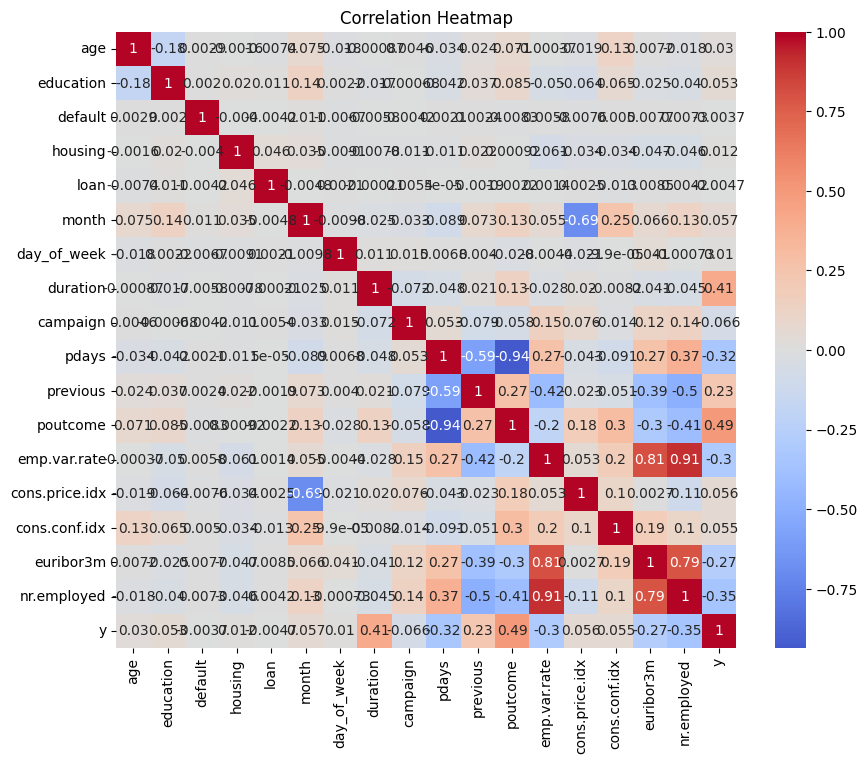

In [30]:
data_r=data.drop(['job'],axis=1)
data_r=data_r.drop(['marital'],axis=1)
data_r=data_r.drop(['contact'],axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(data_r.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

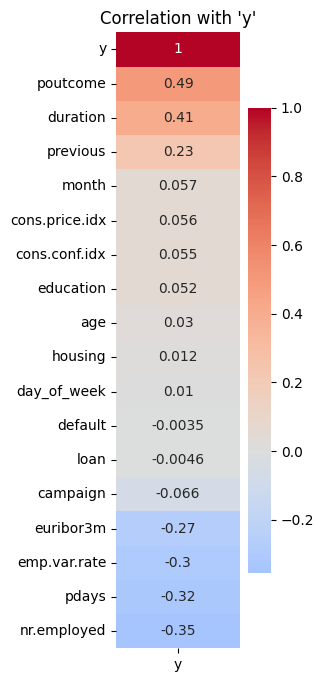

<Figure size 640x480 with 0 Axes>

In [46]:
# Calculate the correlation matrix (assuming your DataFrame is called 'data')
correlation_matrix = data_r.corr()

# Extract only the 'y' column from the correlation matrix
correlation_with_y = correlation_matrix['y'].sort_values(ascending=False)

# Plot the correlation with 'y' as a heatmap
plt.figure(figsize=(2, 8))  # Adjust size as needed
sns.heatmap(correlation_with_y.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with 'y'")
plt.show()
#mlflow
plt.savefig("correlation_heatmap.png")

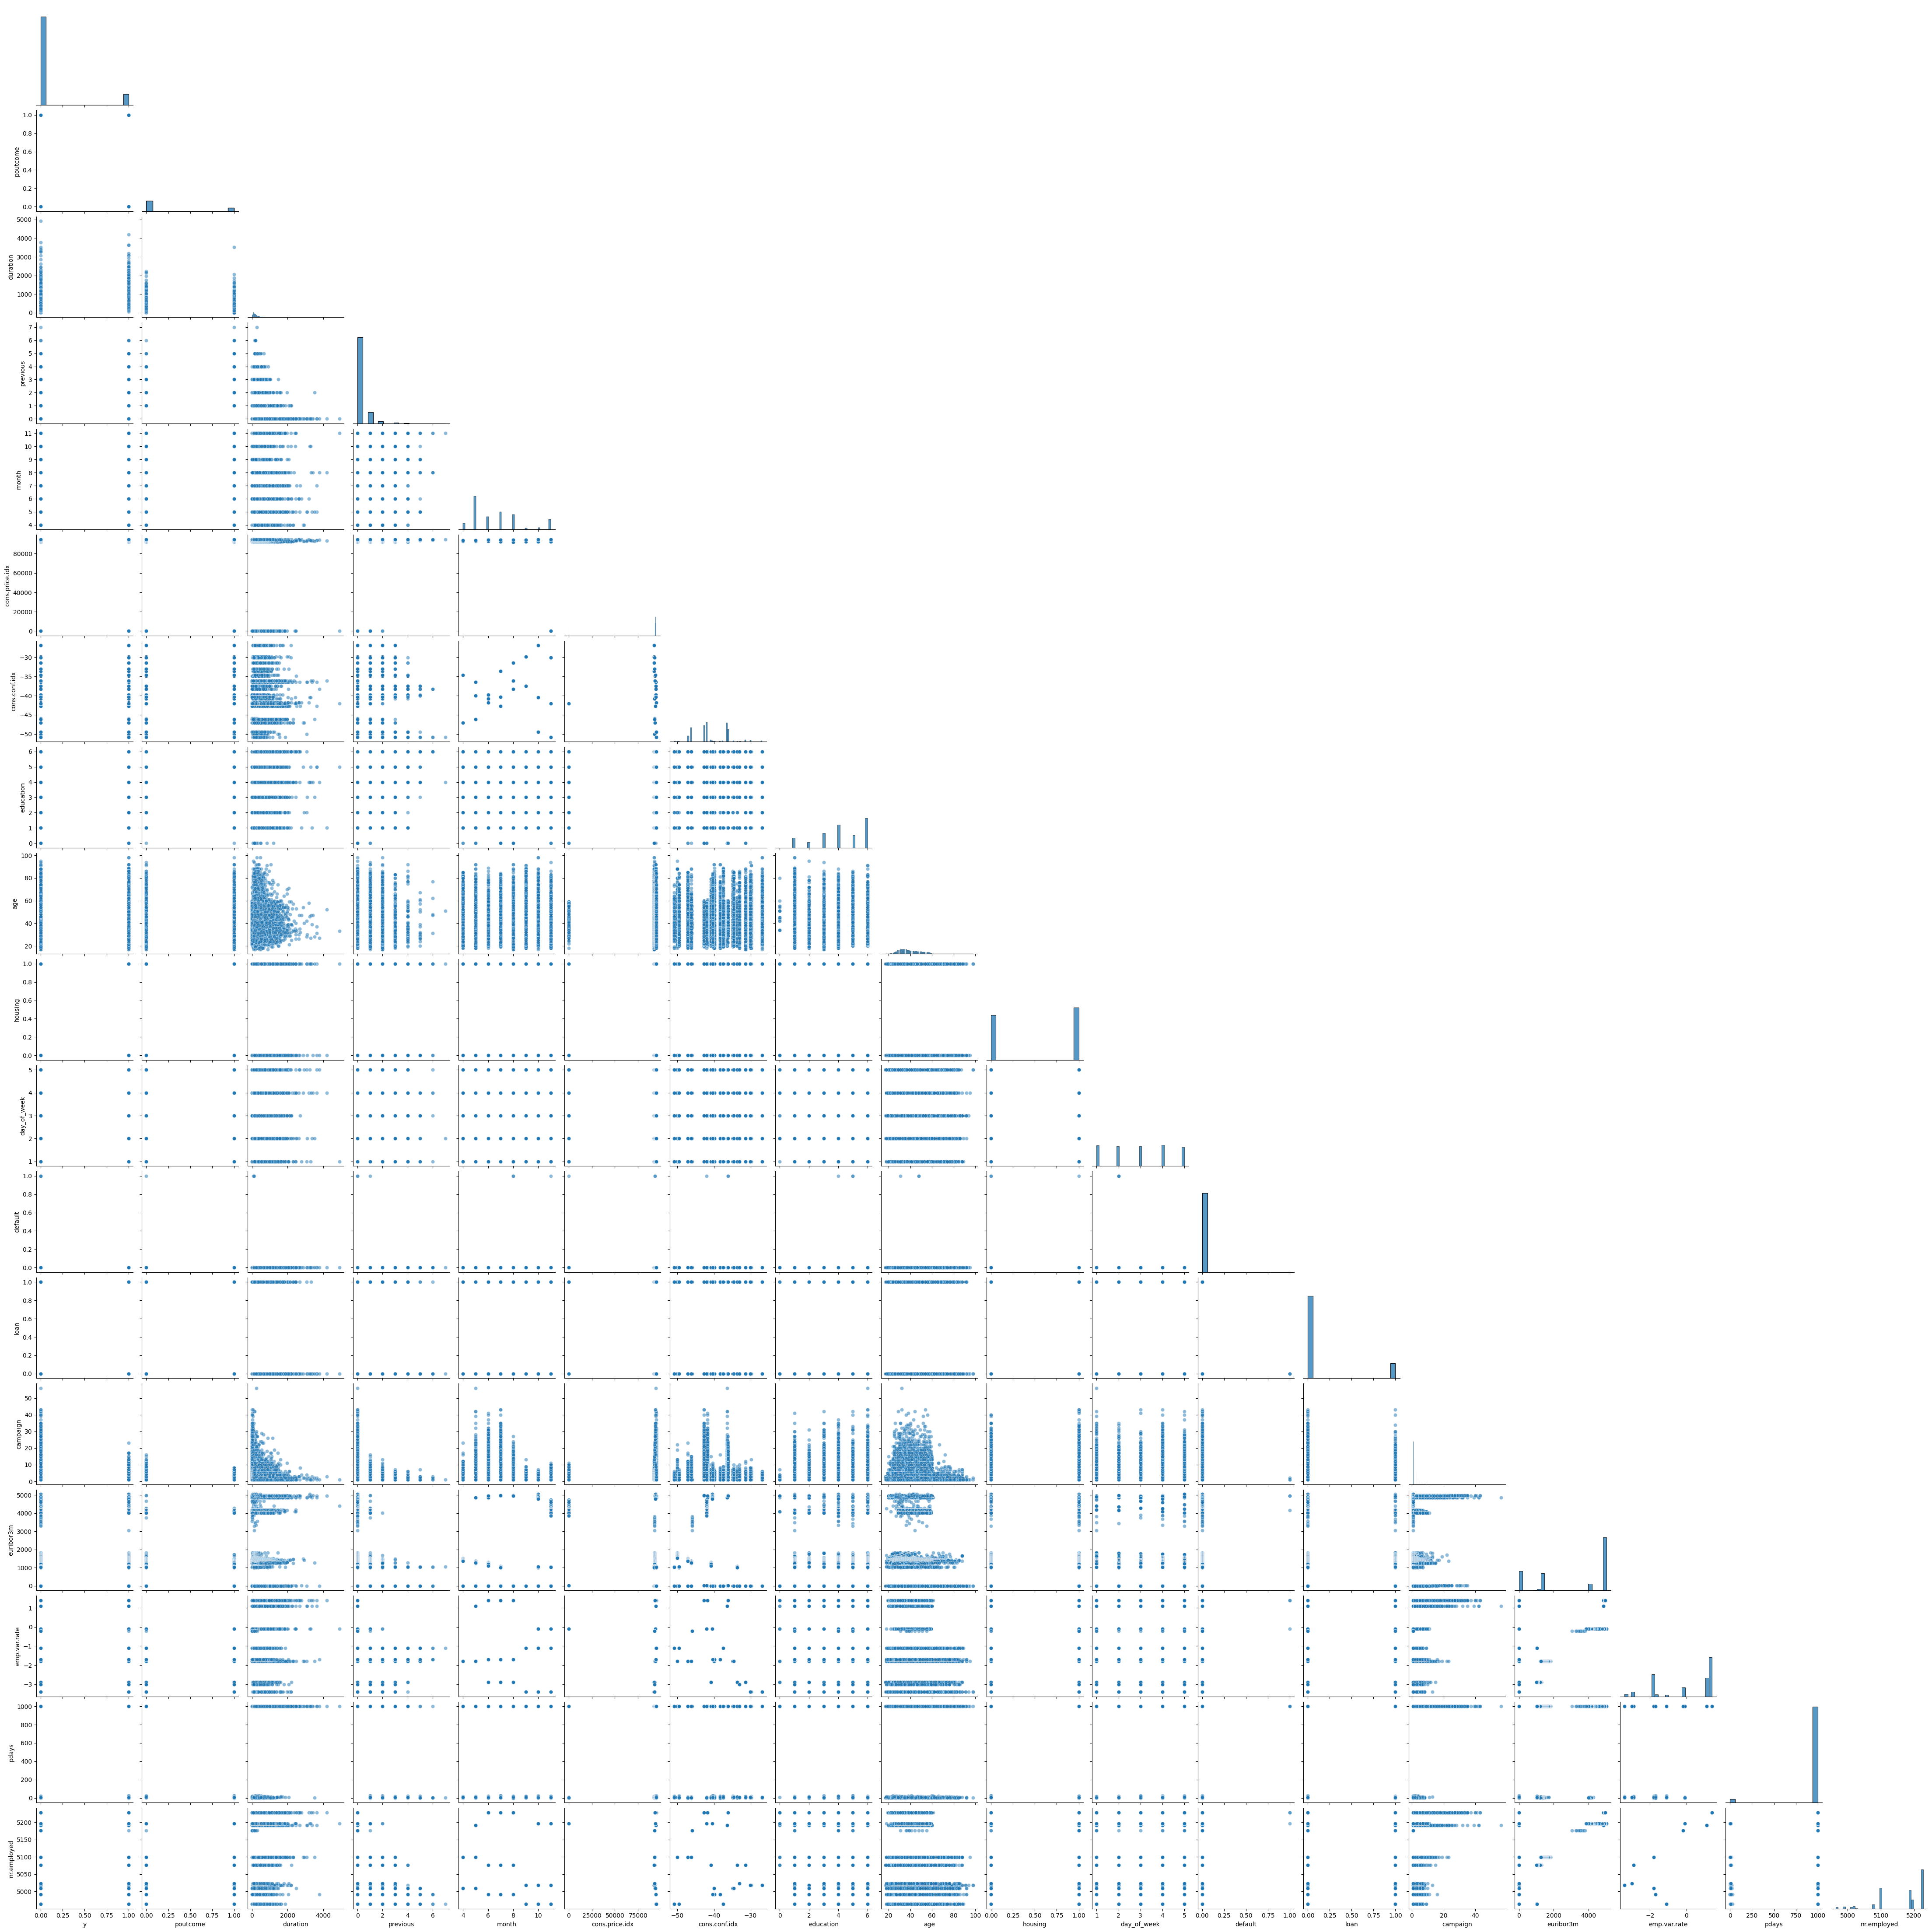

In [32]:
# Select only 'y' and other relevant features (e.g., 'age', 'duration', etc.)
# Adjust the list of features as needed
#features_with_y = ['y', 'age', 'education', 'default', 'housing', 'loan', 'month', 'campaign', 'pdays', 'emp.var.rate']
features_with_y = ['y','poutcome', 'duration', 'previous', 'month', 'cons.price.idx', 'cons.conf.idx',  'education', 'age', 'housing', 'day_of_week', 'default', 'loan', 'campaign', 'euribor3m', 'emp.var.rate', 'pdays', 'nr.employed']
data_subset = data[features_with_y]

# Plot pairplot with only 'y' and selected features
sns.pairplot(data_subset, plot_kws={'alpha': 0.5},corner=True)
plt.show()



#lineal regression


In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
data_r['education']=imputer.fit_transform(data_r[['education']])
data_r['default']=imputer.fit_transform(data_r[['default']])
data_r['housing']=imputer.fit_transform(data_r[['housing']])
data_r['loan']=imputer.fit_transform(data_r[['loan']])

Data Partitioning

In [34]:
X=data_r.drop(['y'], axis = 1)
Y=data_r['y']

In [35]:
feature_names = X.columns
feature_names

Index(['age', 'education', 'default', 'housing', 'loan', 'month',
       'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')

Spliting data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

imputation

In [37]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

implementation

In [38]:
#fitting linear regression to training data
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
#To retrieve the intercept
lr.intercept_

5.685649601888181

Feature importance analysis

In [40]:
coefficients = lr.coef_
feature_importances = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])
feature_importances.sort_values(by='Coefficient', ascending=False, inplace=True)
print(feature_importances)

                 Coefficient
poutcome        2.234784e-01
month           2.584801e-02
default         1.244067e-02
education       5.016272e-03
day_of_week     1.676326e-03
previous        1.070214e-03
cons.conf.idx   1.035062e-03
campaign        6.099712e-04
age             4.888207e-04
duration        4.707849e-04
cons.price.idx  1.431155e-06
euribor3m       5.899208e-07
pdays          -1.407253e-04
loan           -5.437580e-04
nr.employed    -1.144173e-03
housing        -2.322969e-03
emp.var.rate   -8.575397e-03


Model performance on test data

In [41]:
y_pred = lr.predict(X_test)
y_pred

array([ 0.07906241, -0.03938839,  0.12044655, ...,  0.00977331,
        0.18483832,  0.37742982])

In [42]:
#actual values of the test subset vs the predicted values of the test subset:
results_df = {"original":y_test, "predicted":y_pred}
results = pd.DataFrame(results_df)
print("*** results ***")
results.head(100)

*** results ***


,original,predicted
35577,0,0.079062
13950,0,-0.039388
29451,1,0.120447
32295,0,0.065039
27477,0,-0.035180
...,...,...
16799,0,0.091580
20582,0,0.025792
25726,0,0.074365
26158,0,0.004702


In [43]:
# Threshold the predictions
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]


accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.9041029376062151
Precision: 0.6782407407407407
Recall: 0.3103813559322034
F1: 0.4258720930232558


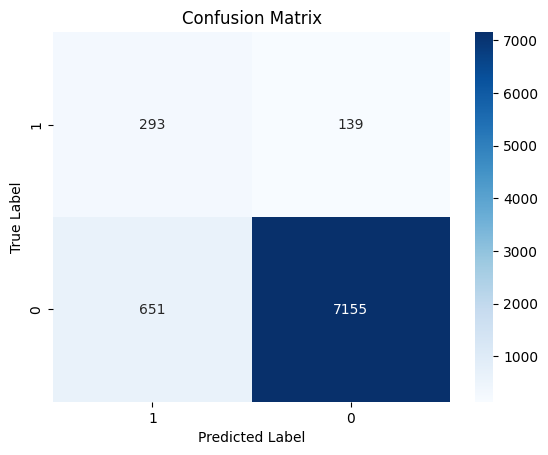

In [48]:
# plot confusion matrix
labels = [1, 0]
cm = confusion_matrix( y_pred_binary,y_test, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
#mlflow
plt.savefig("confusion_matrix.png")

Report ROC-AUC score

In [56]:
print()

35577    0
13950    0
29451    1
32295    0
27477    0
        ..
8337     0
29097    1
30687    0
33048    0
24024    1
Name: y, Length: 8238, dtype: int64


In [77]:
fi1.mi_funcion()

fi1.roc_1(y_test,y_pred_binary,"1")

hi


AttributeError: module 'functions_1' has no attribute 'roc_1'

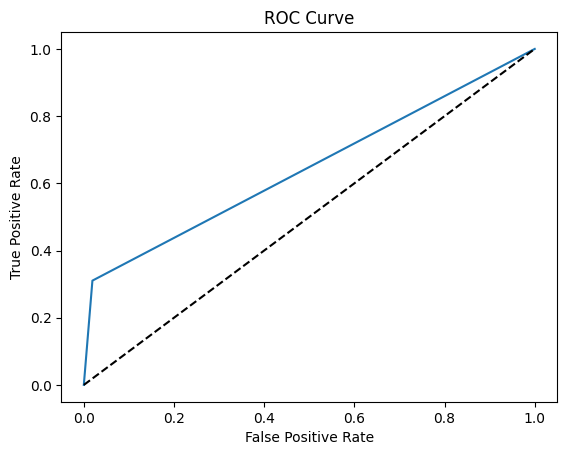

<Figure size 640x480 with 0 Axes>

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_pred_binary)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Save the ROC Curve
plt.savefig("roc_curve.png")

In [50]:

# Start an MLflow run
with mlflow.start_run(run_name="lineal_imbalance"):

# Assuming accuracy, precision, recall, and f1 have been calculated
  mlflow.log_metric("accuracy", accuracy)
  mlflow.log_metric("precision", precision)
  mlflow.log_metric("recall", recall)
  mlflow.log_metric("f1_score", f1)

  mlflow.log_artifact("confusion_matrix.png")
  mlflow.log_artifact("roc_curve.png")

  mlflow.sklearn.log_model(lr, "lienal_all_model")

2024/11/01 04:10:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [88]:
fi1.mi_funcion()

hi
